# Grand Canonical Monte Carlo of atomic species using tabulated pair potentials

In [2]:
from __future__ import division, unicode_literals, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, filecmp, copy
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir
print(workdir)

/Users/mikael/github/faunus-notebooks/tabulated-potential


### Download and build faunus

In [7]:
%%bash -s "$workdir"
cd $1

if [ ! -d "faunus/" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    #git checkout a0f0b46
else
    cd faunus
fi

# if different, copy custom grand.cpp into faunus
if ! cmp ../grand.cpp src/examples/grand.cpp >/dev/null 2>&1
then
    cp ../grand.cpp src/examples/
fi

pwd
CXX=clang++ CC=clang cmake . -DCMAKE_BUILD_TYPE=RelWithDebInfo -DENABLE_APPROXMATH=on &>/dev/null
make example_grand -j4

/Users/mikael/github/faunus-notebooks/tabulated-potential/faunus
[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
Scanning dependencies of target example_grand
[ 90%] Building CXX object src/examples/CMakeFiles/example_grand.dir/grand.cpp.o
[100%] Linking CXX executable grand
[100%] Built target example_grand


### Generate an artificial, tabulated potential

This is just a damped sinus curve to which we later on will add a Coulomb potential. The idea is to replace this with a cation-anion "fingerprint" from all-atom MD. That is a PMF, where the long ranged Coulomb part has been subtracted.

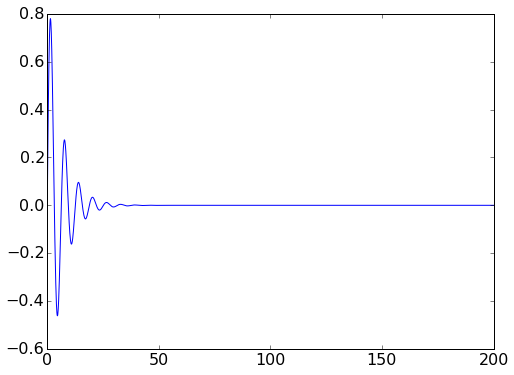

In [4]:
r = np.arange(0, 200, 0.1)
u = np.sin(r)*np.exp(-r/6)
plt.plot(r, u)
d = np.dstack((r,u))
np.savetxt('cation-anion.dat', np.c_[r,u])

### Generate input and run simulation

In [10]:
%cd $workdir

def mkinput():
    js = {
        "atomlist" : {
            "cat" : { "eps": 0.15, "sigma":4.0, "dp":40, "activity":Cs, "q":1.0 },
            "an"  : { "eps": 0.20, "sigma":4.0, "dp":10, "activity":Cs, "q":-1.0 }
        },
        "moleculelist" : { 
            "salt" : { "atoms":"cat an", "atomic":True, "Ninit":50 }
        },
        "moves" : {
            "atomtranslate" : {
                "salt" : { "peratom":True }
            },
            "atomgc": { "molecule": "salt" }
        },
        "energy" : {
            "nonbonded" : {
                "pairpotentialmap" : {
                    "spline" : { "rmin":4.0, "rmax":100, "utol":0.01  },
                    "cat an" : {
                        "fromdisk" : "../cation-anion.dat",
                        "_coulomb" : { "epsr": 80.0 }
                    },
                    "default" : {
                        "lennardjones" : {}
                    }
                }
            }
        },
        "system" : {
            "temperature" : 298.15,
            "cuboid" : { "len":50 },
            "mcloop": { "macro": 10, "micro": micro }
        }
    }
    with open('gc.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

Cs_range = [0.1]
        
for Cs in Cs_range:
    pfx='Cs'+str(Cs)
    if True: #not os.path.isdir(pfx):
        %mkdir -p $pfx
        %cd $pfx
        # equilibration run (no translation)
        !rm -fR state
        micro=1000
        mkinput()
        !../faunus/src/examples/grand > eq
        
        # production run
        micro=1000
        mkinput()
        %time !../faunus/src/examples/grand
        %cd ..
print('done.')

/Users/mikael/github/faunus-notebooks/tabulated-potential
/Users/mikael/github/faunus-notebooks/tabulated-potential/Cs0.1
State file not found.
Reading space state file 'state'. OK!
  Resizing particle vector from 100 --> 16.
  Read 16 particle(s).
  Read 1 group(s).
  Restoring random number generator state.

 .................
  Atom Properties  
 *****************
  Number of entries:       3
  Element info:
    unk   an    cat   

 ...............................
  Simulation Space and Geometry  
 *******************************
  Boundary                 Cuboid
  Volume                   125000 Å³ = 125 nm³ = 1.25e-22 liters
  Sidelengths              50 50 50 (Å)
  Scale directions         XYZ
  Number of particles      16
  Electroneutrality        Yes 0
  System sanity check      Passed
  Number of molecule types 1
  Groups:
    1     [0-15]           salt        N/V = 0.000128 Å⁻³ = 212.549 mM  

 ..........................................
  Energy: Nonbonded N² - pairpotentia